# 1. Import Libraries and Parameters

In [1]:
import numpy as np
from math import log10
import math
import matplotlib.pyplot as plt
import os
import sys
from os import listdir
from os.path import join, isdir
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn import functional as F
import cupy
import re
from torchvision.utils import save_image as imwrite
import itertools
import shutil

In [2]:
# parameters
args = {
    'train': './db',
    'kernel': 51,
    'out_dir': './output_sepconv_pytorch',
    'epochs': 10,
    'batch_size': 4,
    'load_model': None,
    'test_input': './Interpolation_testset/input',
    'gt': './Interpolation_testset/gt',
}
modelType = 'lf'
modelPath = os.path.join(os.getcwd(), 'network-' + modelType + '.pytorch')
input_dir = os.path.join(os.getcwd(), 'my_testset')
output_dir = os.path.join(os.getcwd(), 'my_output')
# checkpoint_dir = os.path.join(os.getcwd(), 'output_sepconv_pytorch', 'checkpoint', 'model_epoch010.pth')
castleInput = os.path.join(os.getcwd(), 'DSLF', 'Castle')
holidayInput = os.path.join(os.getcwd(), 'DSLF', 'Holiday')
sealBallsInput = os.path.join(os.getcwd(), 'DSLF', 'Seal&Balls')

# 2. Model

In [3]:
def to_variable(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x) 

class KernelEstimation(torch.nn.Module):
    def __init__(self, kernel_size):
        super(KernelEstimation, self).__init__()
        self.kernel_size = kernel_size

        def Basic(input_channel, output_channel):
            return torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=input_channel, out_channels=output_channel, kernel_size=3, stride=1, padding=1),
                torch.nn.ReLU(inplace=False),
                torch.nn.Conv2d(in_channels=output_channel, out_channels=output_channel, kernel_size=3, stride=1, padding=1),
                torch.nn.ReLU(inplace=False),
                torch.nn.Conv2d(in_channels=output_channel, out_channels=output_channel, kernel_size=3, stride=1, padding=1),
                torch.nn.ReLU(inplace=False)
            )

        def Upsample(channel):
            return torch.nn.Sequential(
                torch.nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                torch.nn.Conv2d(in_channels=channel, out_channels=channel, kernel_size=3, stride=1, padding=1),
                torch.nn.ReLU(inplace=False)
            )

        def Subnet(ks):
            return torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
                torch.nn.ReLU(inplace=False),
                torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
                torch.nn.ReLU(inplace=False),
                torch.nn.Conv2d(in_channels=64, out_channels=ks, kernel_size=3, stride=1, padding=1),
                torch.nn.ReLU(inplace=False),
                torch.nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                torch.nn.Conv2d(in_channels=ks, out_channels=ks, kernel_size=3, stride=1, padding=1)
            )

        self.moduleConv1 = Basic(6, 32)
        self.modulePool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        self.moduleConv2 = Basic(32, 64)
        self.modulePool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        self.moduleConv3 = Basic(64, 128)
        self.modulePool3 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        self.moduleConv4 = Basic(128, 256)
        self.modulePool4 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        self.moduleConv5 = Basic(256, 512)
        self.modulePool5 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        self.moduleDeconv5 = Basic(512, 512)
        self.moduleUpsample5 = Upsample(512)

        self.moduleDeconv4 = Basic(512, 256)
        self.moduleUpsample4 = Upsample(256)

        self.moduleDeconv3 = Basic(256, 128)
        self.moduleUpsample3 = Upsample(128)

        self.moduleDeconv2 = Basic(128, 64)
        self.moduleUpsample2 = Upsample(64)

        self.moduleVertical1 = Subnet(self.kernel_size)
        self.moduleVertical2 = Subnet(self.kernel_size)
        self.moduleHorizontal1 = Subnet(self.kernel_size)
        self.moduleHorizontal2 = Subnet(self.kernel_size)

        # use this line only when testing on pretrained model. Comment it out when training
        self.load_state_dict(torch.load(modelPath))

    def forward(self, rfield0, rfield2):
        tensorJoin = torch.cat([rfield0, rfield2], 1)

        tensorConv1 = self.moduleConv1(tensorJoin)
        tensorPool1 = self.modulePool1(tensorConv1)

        tensorConv2 = self.moduleConv2(tensorPool1)
        tensorPool2 = self.modulePool2(tensorConv2)

        tensorConv3 = self.moduleConv3(tensorPool2)
        tensorPool3 = self.modulePool3(tensorConv3)

        tensorConv4 = self.moduleConv4(tensorPool3)
        tensorPool4 = self.modulePool4(tensorConv4)

        tensorConv5 = self.moduleConv5(tensorPool4)
        tensorPool5 = self.modulePool5(tensorConv5)

        tensorDeconv5 = self.moduleDeconv5(tensorPool5)
        tensorUpsample5 = self.moduleUpsample5(tensorDeconv5)

        tensorCombine = tensorUpsample5 + tensorConv5

        tensorDeconv4 = self.moduleDeconv4(tensorCombine)
        tensorUpsample4 = self.moduleUpsample4(tensorDeconv4)

        tensorCombine = tensorUpsample4 + tensorConv4

        tensorDeconv3 = self.moduleDeconv3(tensorCombine)
        tensorUpsample3 = self.moduleUpsample3(tensorDeconv3)

        tensorCombine = tensorUpsample3 + tensorConv3

        tensorDeconv2 = self.moduleDeconv2(tensorCombine)
        tensorUpsample2 = self.moduleUpsample2(tensorDeconv2)

        tensorCombine = tensorUpsample2 + tensorConv2

        Vertical1 = self.moduleVertical1(tensorCombine)
        Vertical2 = self.moduleVertical2(tensorCombine)
        Horizontal1 = self.moduleHorizontal1(tensorCombine)
        Horizontal2 = self.moduleHorizontal2(tensorCombine)

        return Vertical1, Horizontal1, Vertical2, Horizontal2

kernel_Sepconv_updateOutput = '''
    extern "C" __global__ void kernel_Sepconv_updateOutput(
        const int n,
        const float* input,
        const float* vertical,
        const float* horizontal,
        float* output
    ) { for (int intIndex = (blockIdx.x * blockDim.x) + threadIdx.x; intIndex < n; intIndex += blockDim.x * gridDim.x) {
        float dblOutput = 0.0;

        const int intSample = ( intIndex / SIZE_3(output) / SIZE_2(output) / SIZE_1(output) ) % SIZE_0(output);
        const int intDepth  = ( intIndex / SIZE_3(output) / SIZE_2(output)                  ) % SIZE_1(output);
        const int intY      = ( intIndex / SIZE_3(output)                                   ) % SIZE_2(output);
        const int intX      = ( intIndex                                                    ) % SIZE_3(output);

        for (int intFilterY = 0; intFilterY < SIZE_1(vertical); intFilterY += 1) {
        for (int intFilterX = 0; intFilterX < SIZE_1(horizontal); intFilterX += 1) {
        dblOutput += VALUE_4(input, intSample, intDepth, intY + intFilterY, intX + intFilterX) * VALUE_4(vertical, intSample, intFilterY, intY, intX) * VALUE_4(horizontal, intSample, intFilterX, intY, intX);
            }
        }

        output[intIndex] = dblOutput;
    } }
'''

kernel_SeparableConvolution_updateGradVertical = '''
    extern "C" __global__ void kernel_SeparableConvolution_updateGradVertical(
        const int n,
        const float* gradLoss,
        const float* input,
        const float* horizontal,
        float* gradVertical
    ) { for (int intIndex = (blockIdx.x * blockDim.x) + threadIdx.x; intIndex < n; intIndex += blockDim.x * gridDim.x) {
        float floatOutput = 0.0;
        float c = 0.0;
    
        const int intBatch   = ( intIndex / SIZE_3(gradVertical) / SIZE_2(gradVertical) / SIZE_1(gradVertical) ) % SIZE_0(gradVertical);
        const int intFilterY = ( intIndex / SIZE_3(gradVertical) / SIZE_2(gradVertical)                        ) % SIZE_1(gradVertical);
        const int intY       = ( intIndex / SIZE_3(gradVertical)                                               ) % SIZE_2(gradVertical);
        const int intX       = ( intIndex                                                                      ) % SIZE_3(gradVertical);
    
        for (int intFilterX = 0; intFilterX < SIZE_1(horizontal); intFilterX++) 
        {
            float product = VALUE_4(gradLoss, intBatch, 0, intY, intX)*              // channel 0
            VALUE_4(input, intBatch, 0, intY + intFilterY, intX + intFilterX)* 
            VALUE_4(horizontal, intBatch, intFilterX, intY, intX) +
            VALUE_4(gradLoss, intBatch, 1, intY, intX)*                          // channel 1     
            VALUE_4(input, intBatch, 1, intY + intFilterY, intX + intFilterX)* 
            VALUE_4(horizontal, intBatch, intFilterX, intY, intX) +
            VALUE_4(gradLoss, intBatch, 2, intY, intX)*                          // channel 2
            VALUE_4(input, intBatch, 2, intY + intFilterY, intX + intFilterX)* 
            VALUE_4(horizontal, intBatch, intFilterX, intY, intX);

            floatOutput += product;
        }
    
        gradVertical[intIndex] = floatOutput;
    } }
'''

kernel_SeparableConvolution_updateGradHorizontal = '''
    extern "C" __global__ void kernel_SeparableConvolution_updateGradHorizontal(
        const int n,
        const float* gradLoss,
        const float* input,
        const float* vertical,
        float* gradHorizontal
    ) { for (int intIndex = (blockIdx.x * blockDim.x) + threadIdx.x; intIndex < n; intIndex += blockDim.x * gridDim.x) {
        float floatOutput = 0.0;
        float c = 0.0;
    
        const int intBatch   = ( intIndex / SIZE_3(gradHorizontal) / SIZE_2(gradHorizontal) / SIZE_1(gradHorizontal) ) % SIZE_0(gradHorizontal);
        const int intFilterX = ( intIndex / SIZE_3(gradHorizontal) / SIZE_2(gradHorizontal)                          ) % SIZE_1(gradHorizontal);
        const int intY       = ( intIndex / SIZE_3(gradHorizontal)                                                   ) % SIZE_2(gradHorizontal);
        const int intX       = ( intIndex                                                                            ) % SIZE_3(gradHorizontal);
    
        for (int intFilterY = 0; intFilterY < SIZE_1(vertical); intFilterY++)
        {
            float product = VALUE_4(gradLoss, intBatch, 0, intY, intX)*             // channel 0
            VALUE_4(input, intBatch, 0, intY + intFilterY, intX + intFilterX)* 
            VALUE_4(vertical, intBatch, intFilterY, intY, intX) + 
            VALUE_4(gradLoss, intBatch, 1, intY, intX)*                         // channel 1
            VALUE_4(input, intBatch, 1, intY + intFilterY, intX + intFilterX)* 
            VALUE_4(vertical, intBatch, intFilterY, intY, intX) + 
            VALUE_4(gradLoss, intBatch, 2, intY, intX)*                         // channel 2
            VALUE_4(input, intBatch, 2, intY + intFilterY, intX + intFilterX)* 
            VALUE_4(vertical, intBatch, intFilterY, intY, intX);
    
            float y = product - c;
            float t = floatOutput + y;
            c = (t - floatOutput) - y;
            floatOutput = t;
        }
    
        gradHorizontal[intIndex] = floatOutput;
    } }
'''

def cupy_kernel(strFunction, objectVariables):
    strKernel = globals()[strFunction]

    while True:
        objectMatch = re.search('(SIZE_)([0-4])(\()([^\)]*)(\))', strKernel)

        if objectMatch is None:
            break
        # end

        intArg = int(objectMatch.group(2))

        strTensor = objectMatch.group(4)
        intSizes = objectVariables[strTensor].size()

        strKernel = strKernel.replace(objectMatch.group(), str(intSizes[intArg]))
    # end

    while True:
        objectMatch = re.search('(VALUE_)([0-4])(\()([^\)]+)(\))', strKernel)

        if objectMatch is None:
            break
        # end

        intArgs = int(objectMatch.group(2))
        strArgs = objectMatch.group(4).split(',')

        strTensor = strArgs[0]
        intStrides = objectVariables[strTensor].stride()
        strIndex = ['((' + strArgs[intArg + 1].replace('{', '(').replace('}', ')').strip() + ')*' + str(intStrides[intArg]) + ')' for intArg in range(intArgs)]

        strKernel = strKernel.replace(objectMatch.group(0), strTensor + '[' + str.join('+', strIndex) + ']')
    # end

    return strKernel


@cupy.util.memoize(for_each_device=True)
def cupy_launch(strFunction, strKernel):
    return cupy.cuda.compile_with_cache(strKernel).get_function(strFunction)


class FunctionSepconv(torch.autograd.Function):
    def __init__(self):
        super(FunctionSepconv, self).__init__()

    # end

    def forward(self, input, vertical, horizontal):
        self.save_for_backward(input, vertical, horizontal)

        intSample = input.size(0)
        intInputDepth = input.size(1)
        intInputHeight = input.size(2)
        intInputWidth = input.size(3)
        intFilterSize = min(vertical.size(1), horizontal.size(1))
        intOutputHeight = min(vertical.size(2), horizontal.size(2))
        intOutputWidth = min(vertical.size(3), horizontal.size(3))

        assert (intInputHeight - intFilterSize == intOutputHeight - 1)
        assert (intInputWidth - intFilterSize == intOutputWidth - 1)

        assert (input.is_contiguous() == True)
        assert (vertical.is_contiguous() == True)
        assert (horizontal.is_contiguous() == True)

        output = input.new_zeros(intSample, intInputDepth, intOutputHeight, intOutputWidth)

        if input.is_cuda == True:
            class Stream:
                ptr = torch.cuda.current_stream().cuda_stream

            # end

            n = output.nelement()
            cupy_launch('kernel_Sepconv_updateOutput', cupy_kernel('kernel_Sepconv_updateOutput', {
                'input': input,
                'vertical': vertical,
                'horizontal': horizontal,
                'output': output
            }))(
                grid=tuple([int((n + 512 - 1) / 512), 1, 1]),
                block=tuple([512, 1, 1]),
                args=[n, input.data_ptr(), vertical.data_ptr(), horizontal.data_ptr(), output.data_ptr()],
                stream=Stream
            )

        elif input.is_cuda == False:
            raise NotImplementedError()

        # end

        return output

    # end

    def backward(self, gradOutput):
        input, vertical, horizontal = self.saved_tensors

        intSample = input.size(0)
        intInputDepth = input.size(1)
        intInputHeight = input.size(2)
        intInputWidth = input.size(3)
        intFilterSize = min(vertical.size(1), horizontal.size(1))
        intOutputHeight = min(vertical.size(2), horizontal.size(2))
        intOutputWidth = min(vertical.size(3), horizontal.size(3))

        assert (intInputHeight - intFilterSize == intOutputHeight - 1)
        assert (intInputWidth - intFilterSize == intOutputWidth - 1)

        assert (gradOutput.is_contiguous() == True)

        gradInput = input.new_zeros(intSample, intInputDepth, intInputHeight, intInputWidth) if self.needs_input_grad[0] == True else None
        gradVertical = input.new_zeros(intSample, intFilterSize, intOutputHeight, intOutputWidth) if self.needs_input_grad[1] == True else None
        gradHorizontal = input.new_zeros(intSample, intFilterSize, intOutputHeight, intOutputWidth) if self.needs_input_grad[2] == True else None

        if input.is_cuda == True:
            class Stream:
                ptr = torch.cuda.current_stream().cuda_stream

            # end

            # vertical grad
            n_v = gradVertical.nelement()
            cupy_launch('kernel_SeparableConvolution_updateGradVertical', cupy_kernel('kernel_SeparableConvolution_updateGradVertical', {
                'gradLoss': gradOutput,
                'input': input,
                'horizontal': horizontal,
                'gradVertical': gradVertical
            }))(
                grid=tuple([int((n_v + 512 - 1) / 512), 1, 1]),
                block=tuple([512, 1, 1]),
                args=[n_v, gradOutput.data_ptr(), input.data_ptr(), horizontal.data_ptr(), gradVertical.data_ptr()],
                stream=Stream
            )

            # horizontal grad
            n_h = gradHorizontal.nelement()
            cupy_launch('kernel_SeparableConvolution_updateGradHorizontal', cupy_kernel('kernel_SeparableConvolution_updateGradHorizontal', {
                'gradLoss': gradOutput,
                'input': input,
                'vertical': vertical,
                'gradHorizontal': gradHorizontal
            }))(
                grid=tuple([int((n_h + 512 - 1) / 512), 1, 1]),
                block=tuple([512, 1, 1]),
                args=[n_h, gradOutput.data_ptr(), input.data_ptr(), vertical.data_ptr(), gradHorizontal.data_ptr()],
                stream=Stream
            )

        elif input.is_cuda == False:
            raise NotImplementedError()

        # end

        return gradInput, gradVertical, gradHorizontal

class SepConvNet(torch.nn.Module):
    def __init__(self, kernel_size):
        super(SepConvNet, self).__init__()
        self.kernel_size = kernel_size
        self.kernel_pad = int(math.floor(kernel_size / 2.0))

        self.epoch = Variable(torch.tensor(0, requires_grad=False))
        self.get_kernel = KernelEstimation(self.kernel_size)
        self.optimizer = optim.Adam(self.parameters(), lr=0.001)
        self.criterion = torch.nn.MSELoss()

        self.modulePad = torch.nn.ReplicationPad2d([self.kernel_pad, self.kernel_pad, self.kernel_pad, self.kernel_pad])

    def forward(self, frame0, frame2):
        h0 = int(list(frame0.size())[2]) # height of the 1st input image
        w0 = int(list(frame0.size())[3]) # width of the 1st input image
        h2 = int(list(frame2.size())[2]) # height of the 2nd input image
        w2 = int(list(frame2.size())[3]) # width of the 2nd input image
        if h0 != h2 or w0 != w2:
            sys.exit('Frame sizes do not match')

        h_padded = False
        w_padded = False
        if h0 % 32 != 0:
            pad_h = 32 - (h0 % 32)
            frame0 = F.pad(frame0, (0, 0, 0, pad_h))
            frame2 = F.pad(frame2, (0, 0, 0, pad_h))
            h_padded = True

        if w0 % 32 != 0:
            pad_w = 32 - (w0 % 32)
            frame0 = F.pad(frame0, (0, pad_w, 0, 0))
            frame2 = F.pad(frame2, (0, pad_w, 0, 0))
            w_padded = True

        Vertical1, Horizontal1, Vertical2, Horizontal2 = self.get_kernel(frame0, frame2)

        tensorDot1 = FunctionSepconv()(self.modulePad(frame0), Vertical1, Horizontal1)
        tensorDot2 = FunctionSepconv()(self.modulePad(frame2), Vertical2, Horizontal2)

        frame1 = tensorDot1 + tensorDot2

        if h_padded:
            frame1 = frame1[:, :, 0:h0, :]
        if w_padded:
            frame1 = frame1[:, :, :, 0:w0]

        return frame1

    def train_model(self, frame0, frame2, frame1):
        self.optimizer.zero_grad()
        output = self.forward(frame0, frame2)
        loss = self.criterion(output, frame1)
        loss.backward()
        self.optimizer.step()
        return loss

    def increase_epoch(self):
        self.epoch += 1

# 3. Test on Several Images

In [4]:
class smallTest:
    def __init__(self, input_dir):
        self.myTransform = transforms.Compose([transforms.ToTensor()])
        self.firstIms = []
        self.secIms = []
        
        for folder, subfolders, files in os.walk(input_dir):
            for file in sorted(files):
                filePath = os.path.join(os.path.abspath(folder), file)
                if ".ipynb_checkpoints" in filePath:
                    continue
                print(filePath)
                if file == "first.png":
                    self.firstIms.append(to_variable(self.myTransform(Image.open(filePath)).unsqueeze(0)))
                if file == "second.png":
                    self.secIms.append(to_variable(self.myTransform(Image.open(filePath)).unsqueeze(0)))
        
    def test(self, model, ouput_dir, mode="one", idx=0):
        print("start testing, mode: {}".format(mode))
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        if mode == "multiple":
            for i in range(len(self.firstIms)):
                frame_out = model.forward(self.firstIms[i], self.secIms[i])
                imwrite(frame_out, os.path.join(ouput_dir, str(i)+'.png'), range=(0, 1))
        else:  # test only 1 image
            frame_out = model(self.firstIms[idx], self.secIms[idx])
            imwrite(frame_out, os.path.join(ouput_dir, str(idx)+'.png'), range=(0, 1))
        print("testing done")
            
    def getFirstIms(self):
        return self.firstIms
    
    def getSecIms(self):
        return self.secIms

### Start testing

In [5]:
# model = SepConvNet(kernel_size=args['kernel'])
# model.eval()
# model.to(torch.device("cuda"))

# for i in range(3):
#     mytest = myTest(input_dir)
#     mytest.test(model, output_dir, "one", i)
#     del mytest

### Plotting results

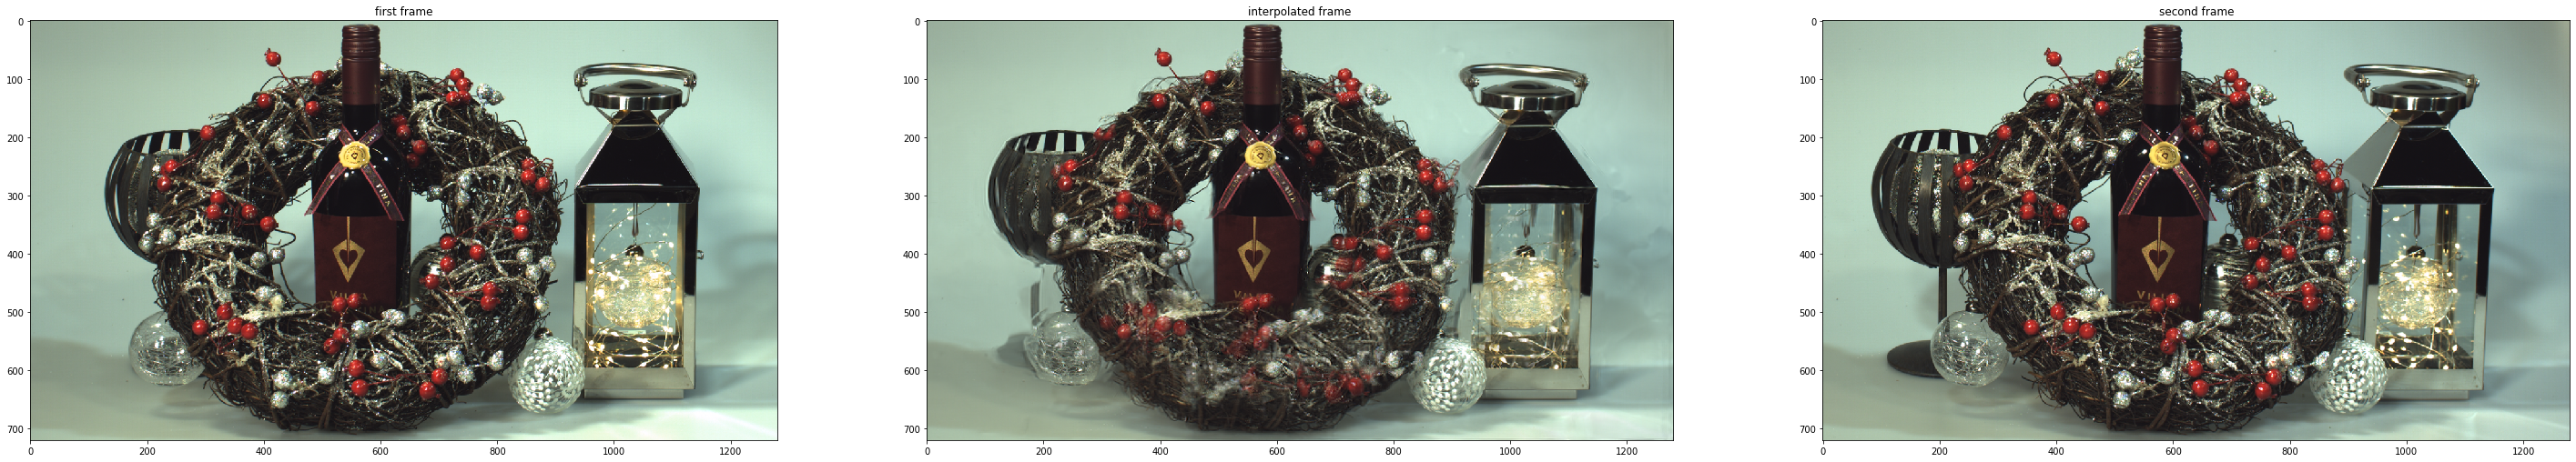

In [6]:
firstIms = []
secIms = []
interpolatedIms = []

for folder, subfolders, files in os.walk(input_dir):
    for file in sorted(files):
        filePath = os.path.join(os.path.abspath(folder), file)
        if ".ipynb_checkpoints" in filePath:
            continue
        if file == "first.png":
            firstIms.append(Image.open(filePath))
        else: 
            secIms.append(Image.open(filePath))
            
for folder, subfolders, files in os.walk(output_dir):
    for file in sorted(files):
        filePath = os.path.join(os.path.abspath(folder), file)
        if ".ipynb_checkpoints" in filePath:
            continue
        interpolatedIms.append(Image.open(filePath))
        
def plotResults(firstIm, interpolatedIm, secIm):
    fig = plt.figure(figsize=(50,20))
    plt.subplot(1,3,1); plt.imshow(firstIm); plt.gca().set_title('first frame')
    plt.subplot(1,3,2); plt.imshow(interpolatedIm); plt.gca().set_title('interpolated frame')
    plt.subplot(1,3,3); plt.imshow(secIm); plt.gca().set_title('second frame')

i = 1
plotResults(firstIms[i], interpolatedIms[i], secIms[i])

# 4. Massive Testing

In [7]:
def to_variable(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x) 

class bigTest:
    def __init__(self):
        self.myTransform = transforms.Compose([transforms.ToTensor()])
        
    def test(self, model, firstImPath, secImPath, outputPath):
        print("Interpolating between {} and {}".format(firstImPath, secImPath))
        firstIm = to_variable(self.myTransform(Image.open(firstImPath)).unsqueeze(0))
        secIm = to_variable(self.myTransform(Image.open(secImPath)).unsqueeze(0))
        frame_out = model(firstIm, secIm)
        imwrite(frame_out, os.path.join(outputPath), range=(0, 1))
        print("---------- Output: {} ----------".format(outputPath))
        
    def getFirstIms(self):
        return self.firstIm
    
    def getSecIms(self):
        return self.secIm

#### Get image names for interpolation with castle folder

In [8]:
def getFileNames(inputDir, distance):
    '''
    Get the lists of corresponding file names we need to interpolate images
    params: inputDir - the path to the folder that contains ground truth images
            distance - (also called decimation) the distance between 2 ground truth 
                        images that we want to get the interpolated image of them
    output: fileNames - the map with keys being the rounds of the interpolating process,
                        the value of each key is a tuple containing the list of names  
                        of corressponding images for interpolating.
                        e.g. if distance = 4, then we have 2 rounds. 
                        Round 1: Interpolating between 1 & 5 to get 3i, 5 & 9 to get 7i, ...
                                 The firstIms list is  [0001.png, 0005.png, 0009.png, ...]
                                 The secIms list is    [0005.png, 0009.png, 0013.png, ...]
                                 The outputIms list is [0003i.png, 0007i.png, 0011i.png, ...]
                        Round 2. Interpolating between 1 & 3i to get 2ii, 3i & 5 to get 4ii, ...
                                 The firstIms list is  [0001.png, 0003i.png, 0005.png, ...]
                                 The secIms list is    [0003i.png, 0005.png, 0007i.png, ...]
                                 The outputIms list is [0002ii.png, 0004ii.png, 0006ii.png, ...]
    '''
    
    numberOfRounds = math.log2(distance)
    assert numberOfRounds % 1 == 0, "distance must be a power of 2 e.g. 2, 4, 8, 16..."
    gtFiles = [] # ground truth files
    for folders, subfolders, files in os.walk(inputDir):
        if '.ipynb_checkpoints' not in folders:
            gtFiles[:] = [f for f in files if not f.startswith("_")] # get all the names of the files in inputDir

    numberOfRounds = int(numberOfRounds)
    fileNames = {}
    for roundNumber in range(1, numberOfRounds + 1):
        fileNames[roundNumber] = ()
        if roundNumber == 1:
            firstIms = gtFiles[0::distance][:-1] 
            secIms = gtFiles[distance::distance]
            outputIms = gtFiles[int(distance/2)::distance]
            outputIms[:] = [(name.split('.')[0] + 'i' + '.' + name.split('.')[1]) for name in outputIms] # put 'i' into the names of interpolated files e.g. 0003.png -> 0003i.png
            print(len(firstIms), len(secIms), len(outputIms))
            print(firstIms)
            print(secIms)
            print(outputIms)
            assert len(firstIms) == len(secIms), "Lengths of first list and second list are different"
            assert len(firstIms) == len(outputIms), "Lengths of first list and output list are different"
            fileNames[roundNumber] += (firstIms, secIms, outputIms)
        else:
            '''
            From round 2 onwards, the firstIms list is concatenated from the firstIms & outputIms of the previous round.
            Similarly, the secIms list is concatenated from the firstIms & outputIms of the previous round.
            '''
            firstIms = sorted(fileNames[roundNumber-1][0] + fileNames[roundNumber-1][2])
            secIms = sorted(fileNames[roundNumber-1][1] + fileNames[roundNumber-1][2])
            outputIms = gtFiles[int(distance/(2**roundNumber))::int(distance/(2**(roundNumber-1)))]
            outputIms[:] = [(name.split('.')[0] + 'i'*roundNumber + '.' + name.split('.')[1]) for name in outputIms]
            print(len(firstIms), len(secIms), len(outputIms))
            print(firstIms)
            print(secIms)
            print(outputIms)
            assert len(firstIms) == len(secIms), print("Lengths of first list and second list are different: {} vs {}".format(len(firstIms),len(secIms)))
            assert len(firstIms) == len(outputIms),  print("Lengths of first list and output list are different: {} vs {}".format(len(firstIms),len(outputIms)))
            fileNames[roundNumber] += (firstIms, secIms, outputIms)
    
    # final output is concatenated from all of the round's outputs, the first images of the first round and also the last image.
    # the length must be 193
    fileNames['final'] = []
    for roundNumber in range(1, numberOfRounds + 1): # concatenating the outputs of all rounds
        fileNames['final'] += fileNames[roundNumber][2]
    fileNames['final'] += fileNames[1][0] # concatenating the first images of the first round
    fileNames['final'].append(fileNames[1][1][-1]) # concatenating the the last image.
    fileNames['final'] = sorted(fileNames['final'])
    assert len(fileNames['final']) == 193, print("Length of the final list is {}, not 193".format(len(fileNames['final'])))
    return fileNames, distance

In [9]:
castleOutput = os.path.join(os.getcwd(), 'DSLF', 'CastleInterpolated')
holidayOutput = os.path.join(os.getcwd(), 'DSLF', 'HolidayInterpolated')
sealBallsOutput = os.path.join(os.getcwd(), 'DSLF', 'SealBallsInterpolated')

def dslfTest(dslfInput, fileNames, distance, model):
    '''
    run the model on the DSLF dataset
    '''
    folderName = os.path.basename(os.path.normpath(dslfInput))
    dslfOutputName = folderName + 'Interpolated' + str(distance)
    dslfOutput = os.path.join(os.getcwd(), 'DSLF', dslfOutputName)
    # for each round:
    #     for each image in the firstIms list:
    #         find the path to the corresponding second image and output image names
    #         apply the model on the first image and second image, output the image with corresponding name
    for key, value in fileNames.items(): # value is a tuple of lists: (firstIms, secIms, outputIms) for each round
        if key != 'final':
            print('round', key)
            for i in value:
                for idx, name in enumerate(value[0]):
                    firstImPath = os.path.join(dslfInput, name)
                    secImPath = os.path.join(dslfInput, value[1][idx])
                    outputImPath = os.path.join(dslfInput, value[2][idx])
                    mytest = bigTest()
                    mytest.test(model, firstImPath, secImPath, outputImPath)
    
    # make the output folder
    if not os.path.exists(dslfOutput):
        os.makedirs(dslfOutput)
    
    # move the interpolated files to the output folder
    for name in fileNames['final']:
        if 'i' in name:
            if not os.path.exists(os.path.join(dslfOutput, name)):
                shutil.move(os.path.join(dslfInput, name), dslfOutput)
        else:
            shutil.copy(os.path.join(dslfInput, name), dslfOutput)

In [10]:
# get the pretrained model to test on the DSLF dataset
model = SepConvNet(kernel_size=args['kernel'])
model.eval()
model.to(torch.device("cuda"))

dist = 4
castleFileNames, castleDistance = getFileNames(castleInput, dist)
dslfTest(castleInput, castleFileNames, castleDistance, model)

holidayFileNames, holidayDistance = getFileNames(holidayInput, dist)
dslfTest(holidayInput, holidayFileNames, holidayDistance, model)

sealBallsFileNames, sealBallsDistance = getFileNames(sealBallsInput, dist)
dslfTest(sealBallsInput, sealBallsFileNames, sealBallsDistance, model) 

dist = 8
castleFileNames, castleDistance = getFileNames(castleInput, dist)
dslfTest(castleInput, castleFileNames, castleDistance, model)

holidayFileNames, holidayDistance = getFileNames(holidayInput, dist)
dslfTest(holidayInput, holidayFileNames, holidayDistance, model)

sealBallsFileNames, sealBallsDistance = getFileNames(sealBallsInput, dist)
dslfTest(sealBallsInput, sealBallsFileNames, sealBallsDistance, model)

dist = 16
castleFileNames, castleDistance = getFileNames(castleInput, dist)
dslfTest(castleInput, castleFileNames, castleDistance, model)

holidayFileNames, holidayDistance = getFileNames(holidayInput, dist)
dslfTest(holidayInput, holidayFileNames, holidayDistance, model)

sealBallsFileNames, sealBallsDistance = getFileNames(sealBallsInput, dist)
dslfTest(sealBallsInput, sealBallsFileNames, sealBallsDistance, model)

dist = 32
castleFileNames, castleDistance = getFileNames(castleInput, dist)
dslfTest(castleInput, castleFileNames, castleDistance, model)

holidayFileNames, holidayDistance = getFileNames(holidayInput, dist)
dslfTest(holidayInput, holidayFileNames, holidayDistance, model)

sealBallsFileNames, sealBallsDistance = getFileNames(sealBallsInput, dist)
dslfTest(sealBallsInput, sealBallsFileNames, sealBallsDistance, model)

48 48 48
['0001.png', '0005.png', '0009.png', '0013.png', '0017.png', '0021.png', '0025.png', '0029.png', '0033.png', '0037.png', '0041.png', '0045.png', '0049.png', '0053.png', '0057.png', '0061.png', '0065.png', '0069.png', '0073.png', '0077.png', '0081.png', '0085.png', '0089.png', '0093.png', '0097.png', '0101.png', '0105.png', '0109.png', '0113.png', '0117.png', '0121.png', '0125.png', '0129.png', '0133.png', '0137.png', '0141.png', '0145.png', '0149.png', '0153.png', '0157.png', '0161.png', '0165.png', '0169.png', '0173.png', '0177.png', '0181.png', '0185.png', '0189.png']
['0005.png', '0009.png', '0013.png', '0017.png', '0021.png', '0025.png', '0029.png', '0033.png', '0037.png', '0041.png', '0045.png', '0049.png', '0053.png', '0057.png', '0061.png', '0065.png', '0069.png', '0073.png', '0077.png', '0081.png', '0085.png', '0089.png', '0093.png', '0097.png', '0101.png', '0105.png', '0109.png', '0113.png', '0117.png', '0121.png', '0125.png', '0129.png', '0133.png', '0137.png', '0141

# Experimenting

In [12]:
path1 = os.path.join(os.getcwd(), 'DSLF', 'Castle', '0001.png')
path2 = os.path.join(os.getcwd(), 'DSLF', 'Castle', '0002.png')

In [13]:
from PIL import Image
import numpy as np

def load_image( infilename ) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data

def save_image( npdata, outfilename ) :
    img = Image.fromarray( np.asarray( np.clip(npdata,0,255), dtype="uint8"), "L" )
    img.save( outfilename )

In [14]:
np.linalg.norm(load_image(path1) - load_image(path2))

7994.445696857288